In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import logging
import os
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# Import from scripts
sys.path.append("..")
from src.data_loader import load_tsla_data
from scripts.lstm import preprocess_data, build_lstm_model,train_lstm, forecast_lstm,evaluate_lstm, plot_lstm_results



In [3]:
data = load_tsla_data('data/TSLA_cleaned.csv')



In [4]:
print("Initial NaNs:", data.isna().sum())

Initial NaNs: Price           0
Close           0
High            0
Low             0
Volume          0
Daily_Return    0
Rolling_Mean    0
Rolling_Std     0
Z_Score         0
dtype: int64


In [5]:

data.head()

,Price,Close,High,Low,Volume,Daily_Return,Rolling_Mean,Rolling_Std,Z_Score
Date,,,,,,,,,
2015-02-17,13.623333,13.713333,13.433333,13.713333,59694000,-0.140787,13.940933,0.583636,-0.895868
2015-02-18,13.630667,13.744667,13.506667,13.611333,40704000,0.228492,13.917978,0.577107,-0.895605
2015-02-19,14.114000,14.162667,13.583333,13.666667,77311500,3.041181,13.914067,0.574963,-0.892099
2015-02-20,14.474000,14.506667,13.987333,14.052000,89731500,2.428920,13.920333,0.580523,-0.889213
2015-02-23,13.822667,14.546667,13.755333,14.377333,127497000,0.275735,13.930111,0.588737,-0.888878


In [6]:
# Preprocess
X_train, y_train, X_test, y_test, scaler = preprocess_data(data, look_back=60)


In [7]:
# Build model
model = build_lstm_model(input_shape=(X_train.shape[1], 1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
# Train
trained_model, history = train_lstm(model, X_train, y_train)

Epoch 1/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - loss: 0.0245 - val_loss: 0.0270 - learning_rate: 0.0010
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0237 - val_loss: 0.0271 - learning_rate: 0.0010
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0224 - val_loss: 0.0270 - learning_rate: 0.0010
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 0.0215 - val_loss: 0.0270 - learning_rate: 0.0010
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.0210 - val_loss: 0.0269 - learning_rate: 0.0010
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 0.0233 - val_loss: 0.0269 - learning_rate: 0.0010
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 0.0238 - val_loss: 0.0270 - learning_rate: 2.0000e-04
Epoch 8/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.0234 - val_loss: 0.0270 - learning_rate: 2.0000e-04
Epoch 9/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - loss: 0.0227 - val_loss: 0.0271 - learning_rate: 2.0000e-0

In [9]:
# Forecast
predictions = forecast_lstm(trained_model, X_test, scaler, data)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
Scaled predictions sample: [[-0.12452505]
 [-0.12176704]
 [-0.12105477]
 [-0.11949754]
 [-0.11885146]]
Inverse transformed sample: [[-0.00248144]
 [-0.0019049 ]
 [-0.00175601]
 [-0.00143048]
 [-0.00129542]]
Index range: 2044 to 2504
Last prices sample: [197.33000183 207.78999329 202.69000244 198.74000549 190.67999268]
Final prices sample: [196.84033521 207.39417312 202.33407628 198.45571748 190.43297678]


In [10]:
# Align predictions
valid = data.iloc[-len(predictions):].copy()
valid['Predictions'] = predictions

MAE: 5.57
RMSE: 8.20
MAPE: 2.25%


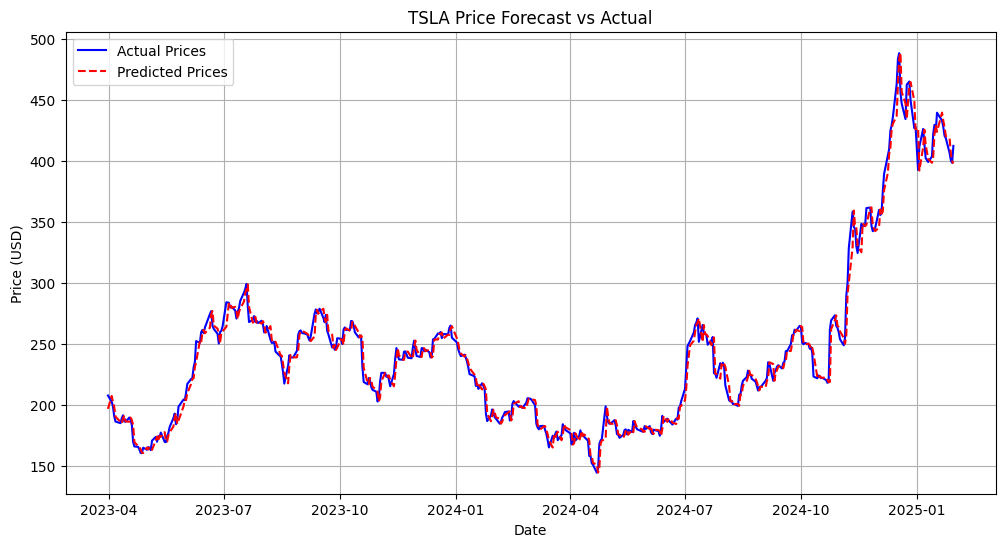

In [11]:
# Evaluate
evaluate_lstm(valid['Close'], valid['Predictions'])
plot_lstm_results(valid['Close'], valid['Predictions'], valid.index)